In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from scipy.io import loadmat
import seaborn as sns
import pandas as pd

Visualisation des logs et de la matrice de confusion...
Matrice de confusion chargée depuis recorddata/confusion_matrix_step1.pt
Précision globale: 0.0100


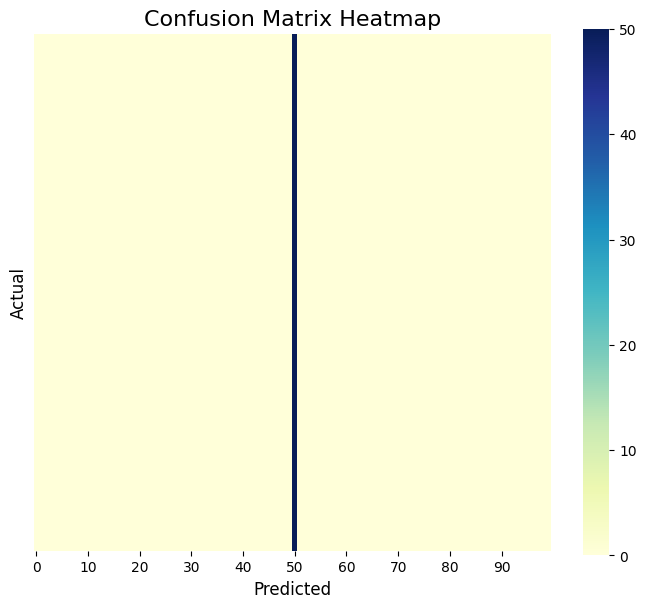

Chargement du fichier: recorddata/Test_0_63_step1.mat


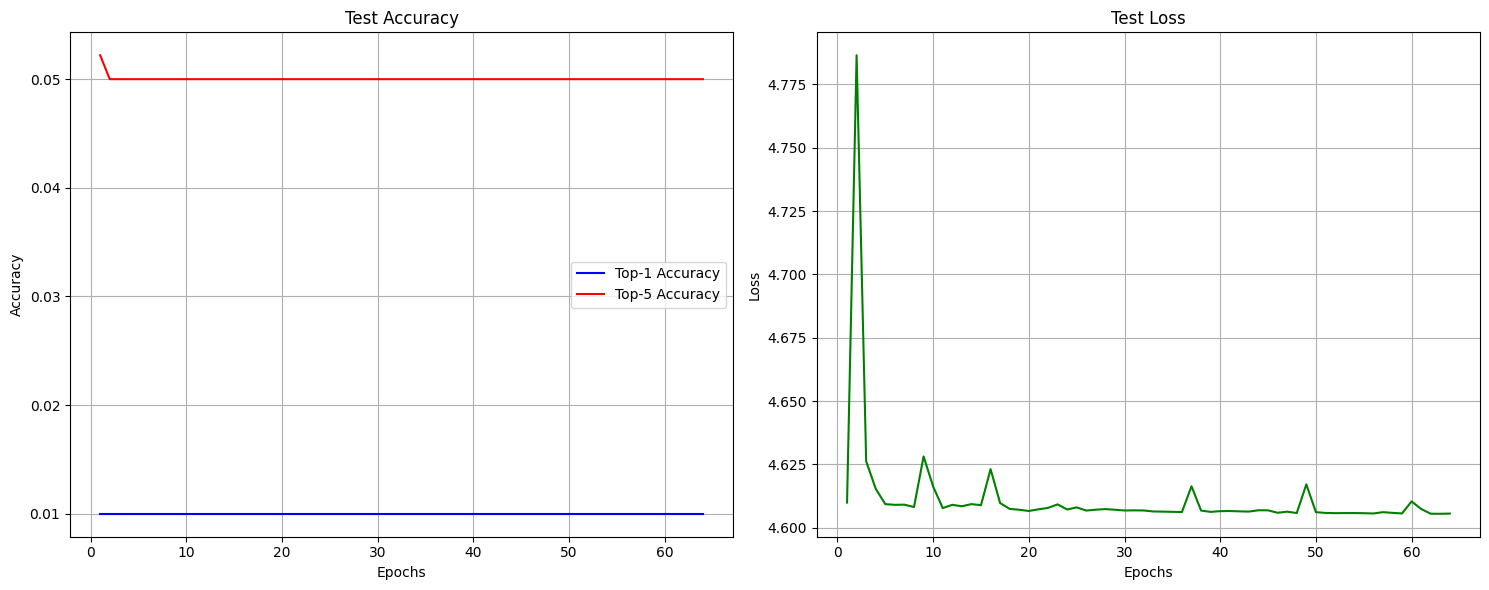

In [7]:


# Chemins des fichiers
save_model_path = 'savemodels/'  # Dossier contenant les fichiers .h5 et .npy
record_path = 'recorddata/'     # Dossier contenant les fichiers .mat
name_suffix = 'step1'          # Suffixe utilisé dans vos fichiers

# Chargement du modèle avec les meilleurs résultats
def load_best_model(net, save_path=save_model_path):
    """Charge le modèle avec la meilleure précision."""
    max_acc_file = os.path.join(save_path, f'max_acc{name_suffix}.npy')
    model_file = os.path.join(save_path, f'max_acc{name_suffix}.h5')
    
    if os.path.exists(max_acc_file) and os.path.exists(model_file):
        max_acc = np.load(max_acc_file).item()
        net.load_state_dict(torch.load(model_file))
        print(f"Modèle chargé avec une précision maximale de: {max_acc:.4f}")
        return net, max_acc
    else:
        print("Fichiers du meilleur modèle non trouvés")
        return None, None

# Chargement et visualisation des logs d'entraînement
def visualize_training_logs(record_path=record_path):
    """Charge et visualise les logs d'entraînement à partir des fichiers .mat"""
    # Chercher le dernier fichier de log
    mat_files = [f for f in os.listdir(record_path) if f.endswith(f'{name_suffix}.mat')]
    if not mat_files:
        print("Aucun fichier .mat trouvé dans le dossier spécifié")
        return None
    
    # Trier par date de modification pour obtenir le plus récent
    mat_files.sort(key=lambda x: os.path.getmtime(os.path.join(record_path, x)), reverse=True)
    latest_mat = os.path.join(record_path, mat_files[0])
    
    print(f"Chargement du fichier: {latest_mat}")
    data = loadmat(latest_mat)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    iterations = record_data[:, 1]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Création des graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique de précision
    ax1.plot(epochs, test_top1, 'b-', label='Top-1 Accuracy')
    ax1.plot(epochs, test_topk, 'r-', label='Top-5 Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Test Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Graphique de perte
    ax2.plot(epochs, test_loss, 'g-')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Test Loss')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return record_data

# Visualisation de la matrice de confusion
def visualize_confusion_matrix():
    """Visualise la matrice de confusion à partir d'un fichier .pt ou .csv."""
    try:
        # Essayer de charger depuis un fichier .pt
        confusion_matrix_path = os.path.join(record_path, f'confusion_matrix_{name_suffix}.pt')
        if os.path.exists(confusion_matrix_path):
            confusion_matrix = torch.load(confusion_matrix_path)
            if isinstance(confusion_matrix, torch.Tensor):
                confusion_matrix = confusion_matrix.cpu().numpy()
            df = pd.DataFrame(confusion_matrix)
            print(f"Matrice de confusion chargée depuis {confusion_matrix_path}")
        else:
            # Essayer de charger depuis un fichier .csv
            csv_path = os.path.join(record_path, f'confusion_matrix_{name_suffix}.csv')
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path, index_col=0)
                print(f"Matrice de confusion chargée depuis {csv_path}")
            else:
                print(f"Aucun fichier de matrice de confusion trouvé à {confusion_matrix_path} ou {csv_path}")
                return

        # Calculer l'accuracy
        if isinstance(df, pd.DataFrame):
            accuracy = df.values.diagonal().sum() / df.values.sum()
            print(f"Précision globale: {accuracy:.4f}")

        # Visualisation
        plt.figure(figsize=(7, 6))
        sns.heatmap(df, 
                    annot=False,
                    cmap="YlGnBu",
                    cbar=True,
                    xticklabels=10,
                    yticklabels=False,  # Masquer les labels sur l'axe Y
                    square=True)

        plt.title("Confusion Matrix Heatmap", fontsize=16)
        plt.xlabel("Predicted", fontsize=12)
        plt.ylabel("Actual", fontsize=12)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erreur lors de la visualisation de la matrice de confusion: {e}")

# Exemple d'utilisation
if __name__ == "__main__":
    print("Visualisation des logs et de la matrice de confusion...")
    
    # Visualiser la matrice de confusion
    visualize_confusion_matrix()
    
    # Charger et visualiser les logs d'entraînement
    visualize_training_logs()